<a href="https://colab.research.google.com/github/sebatlab/Antaki2021/blob/main/Antaki2021_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import scipy.stats
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import statsmodels.stats.multitest
from statsmodels.stats.contingency_tables import Table2x2
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Figure 1

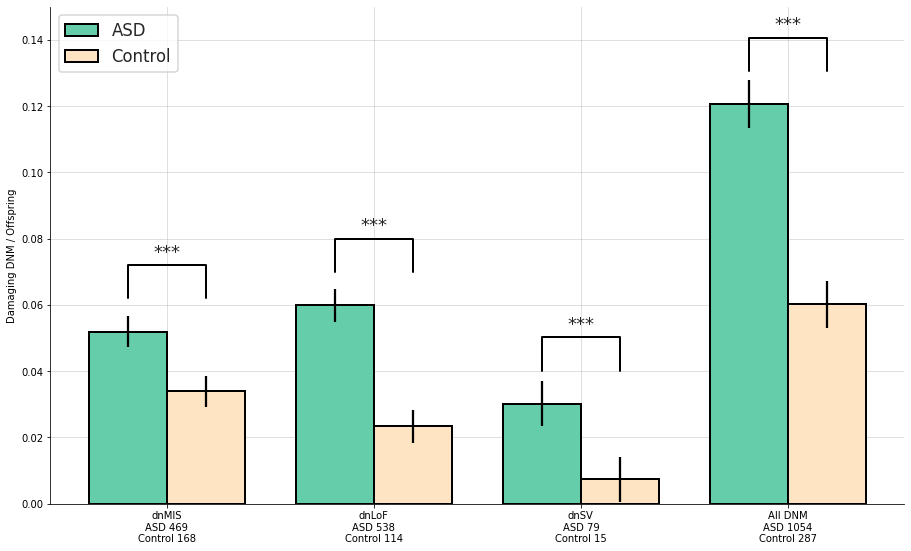

In [2]:
# Figure 1A
# df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20200625.csv", sep=",")
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20210709.csv", sep=",")


df['dnAll'] = df['dnLOF'] + df['dnMIS'] + df['dnSV'].fillna(0)
cols = ['dnMIS','dnLOF','dnSV','dnAll'] 

def calculate_plot_data(df, col):
  df_tmp = df.dropna(subset=[col])
  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]

  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = cas[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])

  # Put relevant data into tuples
  cas_data = (cas_mean, cas_ci, num_cas, cas_sum)
  ctl_data = (ctl_mean, ctl_ci, num_ctl, ctl_sum)
  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  return cas_data, ctl_data, p_val

def get_all_plot_data(df, cols):
  cas_data_arr = []
  ctl_data_arr = []
  p_vals_arr = []
  for col in cols:
    cas_data, ctl_data, p_val = calculate_plot_data(df, col)
    cas_data_arr.append(cas_data)
    ctl_data_arr.append(ctl_data)
    p_vals_arr.append(p_val)
  
  return cas_data_arr, ctl_data_arr, p_vals_arr

def plot_bar(ax, xbar, a, col, wid, lab, buf = 0):
    ax.bar(
        x = [x + buf for x in xbar],
        height = [x[0] for x in a],
        width = wid,
        yerr = [x[1] for x in a],
        color = col,
        label = lab,
        linewidth = 2,
        edgecolor = 'k',
    )


def plot_ci2(cas_data_arr, ctl_data_arr, p_vals_arr):
  ymax = 0.15

  f, ax = plt.subplots(1,1,figsize=(13,8))
  sns.set_context('talk')
  sns.set_style('ticks')
  ax.xaxis.grid(alpha=0.5)
  ax.yaxis.grid(alpha=0.5)

  pal = ['mediumaquamarine', 'bisque']
  width = 0.75
  pheight = 0.01
  xbar = [x for x in range(0, len(cols)*2, 2)]
  px = [x/2 for x in xbar]
  plot_bar(ax, xbar, cas_data_arr, pal[0], width, 'ASD')
  plot_bar(ax, xbar, ctl_data_arr, pal[1], width, 'Control', buf = width)

  ax.legend(loc = 2)
  sns.despine(ax=ax)

  ax.set_xlabel('')
  ax.set_ylabel('Damaging DNM / Offspring')
  ax.set_xticks([x + (width/2) for x in xbar])
  ax.set_xticklabels(['{}\nASD {}\nControl {}'.format(
      e,
      int(cas_data_arr[i][2]),
      int(ctl_data_arr[i][2]))
      for i,e in enumerate(xlabs)])
  ax.set_ylim(0,ymax)
  bufff=0.01
  py = [cas_data_arr[0][0]+bufff,
        cas_data_arr[1][0]+bufff,
        cas_data_arr[2][0]+bufff,
        cas_data_arr[3][0]+bufff]

  # Add lines (the p-value astericks will be above these branched lines)
  ax.plot([xbar[0], xbar[0], xbar[0] + width, xbar[0] + width], [py[0], py[0] + pheight, py[0] + pheight, py[0]], lw = 2, c = "k")
  ax.plot([xbar[1], xbar[1], xbar[1] + width, xbar[1] + width], [py[1], py[1] + pheight, py[1] + pheight, py[1]], lw = 2, c = "k")
  ax.plot([xbar[2], xbar[2], xbar[2] + width, xbar[2] + width], [py[2], py[2] + pheight, py[2] + pheight, py[2]], lw = 2, c = "k")
  ax.plot([xbar[3], xbar[3], xbar[3] + width, xbar[3] + width], [py[3], py[3] + pheight, py[3] + pheight, py[3]], lw = 2, c = "k")

  # Plot the p-value astericks
  for i, p_val in enumerate(p_vals_arr):
    ybuf = 0.0
    x = xbar[i] + (width/2)
    y = py[i] + pheight + 0.004
    if p_val < 0.05:
      asterick = get_asterick(p_val)
      ax.text(s=asterick, x=x, y=y, ha="center", va="center")
  
  sns.despine(ax=ax)
  ax.set_axisbelow(True)
  f.tight_layout()
  f.savefig("fig1_dnmrates_final.png")
  f.savefig("fig1_dnmrates_final.svg")
  f.show()
  return ax
      
def get_asterick(p_val):
  if p_val < 0.001:  return "***"
  elif p_val < 0.01: return "**"
  elif p_val < 0.05: return "*"
  return


xlabs = ['dnMIS','dnLoF','dnSV','All DNM']
cas_data_arr, ctl_data_arr, p_vals_arr = get_all_plot_data(df, cols)
ax = plot_ci2(cas_data_arr, ctl_data_arr, p_vals_arr)

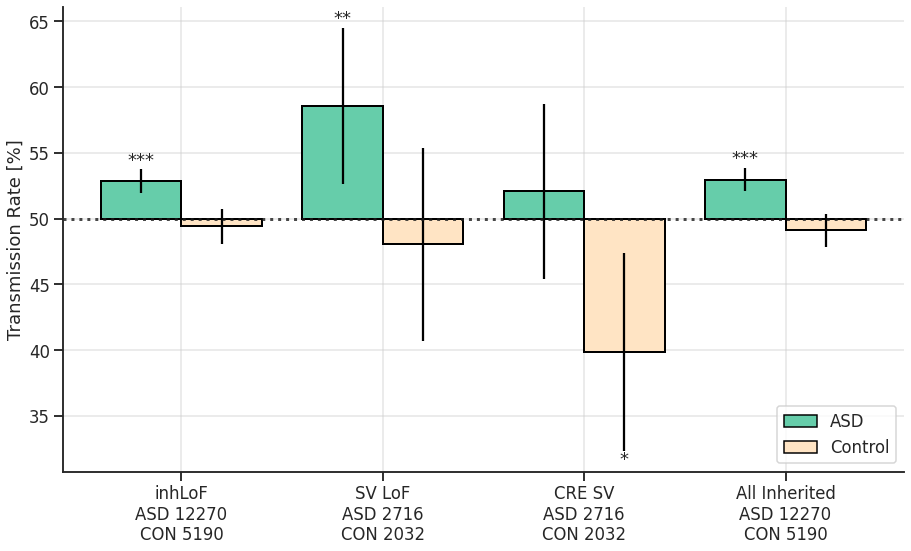

In [4]:
# Figure 1B

# Functions
def add_sig_lines(ax, x1, x2, y, h):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw = 2, c = 'k')

def format_p(pv):
    fmt = ''
    if pv < 0.05: fmt='*'
    if pv < 0.01: fmt='**'
    if pv < 0.001: fmt='***'
    return fmt

def add_tbar(df, ax, x, width = 0.75, pbuf = 0.7):
    pal = ['mediumaquamarine','bisque']
    ax.bar(
        x = x,
        height = (df['aff_trate'] - 0.5)*100,
        width = width,
        yerr = df['aff_tci']*100,
        color = pal[0],
        edgecolor = 'k',
        linewidth = 2,
    )
    ap = df['aff_tpval'].values[0]
    if ap <= 0.05:
        ax.text(
            x = x,
            y = ((df['aff_trate'].values[0] - 0.5)*100) + (df['aff_tci'].values[0]*100) + pbuf,
            s = '{}'.format(format_p(ap)),
            ha = 'center',
            va = 'center'
        )

    ax.bar(
        x = x + width,
        height = (df['con_trate'] - 0.5)*100,
        width = width,
        yerr = df['con_tci']*100,
        color = pal[1],
        edgecolor = 'k',
        linewidth = 2,
    
    )

    cp = df['con_tpval'].values[0]
    if cp <= 0.05:
        ax.text(
            x = x + width,
            y = ((df['con_trate'].values[0] - 0.5)*100) - (df['con_tci'].values[0]*100) - pbuf,
            s = '{}'.format(format_p(cp)),
            ha = 'center',
            va = 'center'
        )
    chi = df['tot_chisq'].values[0]
    pheight = 2

df = pd.read_csv("all_t1burden_tdt_results.tsv",sep="\t")
groups = ['snv_indel_lof','sv_lof','cresv','combined_lof_cre']
df = df[df["group_id"].isin(groups)]

# Plotting
ind = []
for x in range(1, len(groups) + 1):
  ind.append(x)

sns.set_context("talk")
f, ax = plt.subplots(1, 1, figsize = (13,8))

width = 2/5
for i,g in enumerate(groups):
  add_tbar(df.loc[df["group_id"] == g], ax, ind[i], width)

ax.set_ylabel('Transmission Rate [%]')

ytick_step = 5
rng = 20
ax.set_yticks([x for x in range(-1*rng, rng + ytick_step, ytick_step)])
ax.set_yticklabels([x for x in range(50 - rng, 50 + rng + ytick_step, ytick_step)])
ax.set_xticks([x + (width/2) for x in ind])

xlabs = ['inhLoF','SV LoF','CRE SV','All Inherited']
xtix = [
    '{}\nASD {}\nCON {}'.format(
        xlabs[i],
        df.loc[df['group_id'] == g]['n_asd_tot'].values[0],
        df.loc[df['group_id'] == g]['n_con_tot'].values[0],
    )
    for i,g in enumerate(groups)
]

xmin, xmax = ax.set_xlim()
ax.hlines(y = 0, xmin = xmin, xmax = xmax, alpha = 0.8, color = '#1c1c1c', linestyle = ':',linewidth=3)
ax.set_xticklabels(xtix)

pal = ['mediumaquamarine', 'bisque']
leg = [
    Patch(facecolor = pal[0], edgecolor = 'k', label = 'ASD'),
    Patch(facecolor = pal[1], edgecolor = 'k', label = 'Control')
]

ax.legend(handles = leg, loc = 4)
ax.xaxis.grid(alpha = 0.5)
ax.yaxis.grid(alpha = 0.5)
ax.set_axisbelow(True)
sns.despine(ax = ax)
f.tight_layout()
f.savefig("fig1_tdt_final.png")
f.savefig("fig1_tdt_final.svg")


In [5]:
def ttest(a,popmean=0):
    return scipy.stats.ttest_1samp(a,popmean=popmean)[1]

def paired_ttest(a,b):
    return scipy.stats.ttest_ind(a,b)[1]

def mean_ci(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def return_plot_data(df,c):
    m,ci = mean_ci(df[c])
    return( (m,ci,len(set(df['IID'])),ttest(df[c]) ) )

def calc_plot_data(df,cols):
    asd,con,pvs=[],[],[]
    # foreach column
    for c in cols:
        cas = df.loc[df['Phenotype']==1].dropna(subset=[c])
        ctl = df.loc[df['Phenotype']!=1].dropna(subset=[c])

        # mean, ci95, n-samples, pvalue, paired-t-test
        pvs.append(paired_ttest(cas[c],ctl[c]))
        asd.append(return_plot_data(cas,c))
        con.append(return_plot_data(ctl,c))
    
    return asd,con,pvs

def plot_bar(ax,xbar,a,col,wid,lab,buf=0):
    ax.bar(
        x=[x+buf for x in xbar],
        height=[x[0] for x in a],
        width=wid,
        yerr=[ x[1]  for x in a],
        color=col,
        label=lab,
        edgecolor='k',
        linewidth=2,
    )
    pbuf=0.5e-06
    for i,x in enumerate(xbar):
        if a[i][-1]>0.05: continue
        y = a[i][0]+a[i][1]+pbuf
        if 'Con' in lab:y=a[i][0]-a[i][1]-pbuf
        ax.text(
            x=x+buf,
            y=y,
            s=format_p(a[i][-1]),
            ha='center', va='center'
        )
    
def format_p(pv):
    fmt = ''
    if pv<0.05: fmt='*'
    if pv<0.01: fmt='**'
    if pv<0.001: fmt='***'
    return fmt

def add_sig_lines(ax,x1,x2,y,h):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')

def plot_ci(ax,df,cols,xlabs):
    asd,con,pvs = calc_plot_data(df,cols)
    pal = ['mediumaquamarine','bisque']
    width=0.75
    xbar = [x for x in range(0,len(cols)*2,2)]
    plot_bar(ax,xbar,asd,pal[0],width,'ASD : {}'.format(asd[0][2]))
    plot_bar(ax,xbar,con,pal[1],width,'Control : {}'.format(con[0][2]),buf=width)

    ax.legend(loc=4)
    ax.set_xlabel('')
    ax.set_ylabel('Child - Midparent PRS')
    
    # x ticks
    ax.set_xticks(np.array(xbar)+width/2)
    ax.set_xticklabels(
        ['{LAB}'.format(LAB=e,ASD=asd[i][2],CON=con[i][2]) for i,e in enumerate(xlabs)],
        fontsize=24
    )
    ax.xaxis.grid(alpha=0.5)
    ax.yaxis.grid(alpha=0.5)
    pheight=0.1e-05
    pbuf=0.1e-05
    for i,pv in enumerate(pvs):
        x = xbar[i]
        y = asd[i][0]+asd[i][1]+pbuf
        print(pv)
        if 1 > 2:
        #if pv<=0.05:
            add_sig_lines(
                ax,
                x,
                x+width,
                y,
                pheight
            )
            ax.text(
                s='P={:.2e}'.format(pv),
                x=x+(width/2),
                y=y+(pbuf*1.5),
                ha='center',
                va='center',
            )    

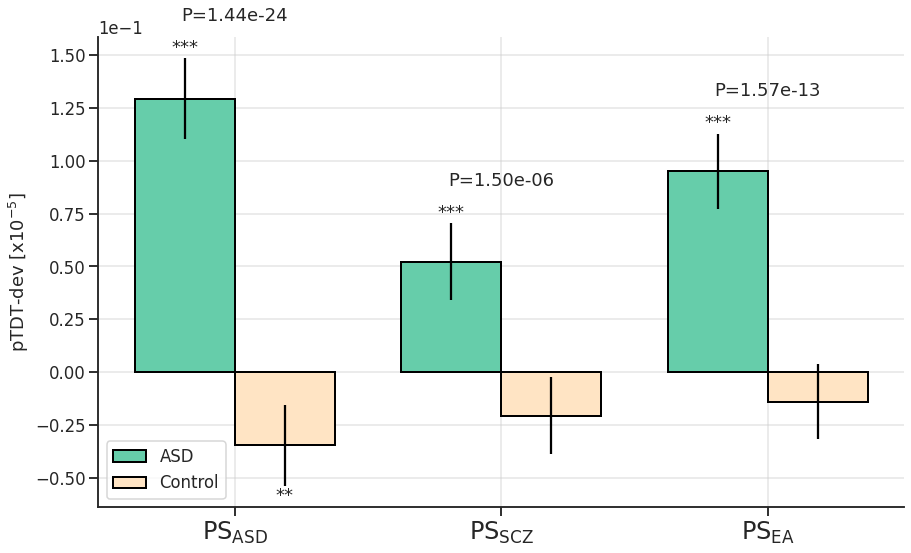

In [6]:
# Figure 1C

# df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20200625.csv", sep=",")
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20210709.csv", sep=",")


df = df[df["EUR Ancestry"] == 1]
cols = ['pTDT ASD Dev','pTDT SCZ Dev', 'pTDT EA Dev']


def calculate_plot_data(df, col):
  df_tmp = df.dropna(subset=[col])
  cas = df_tmp[df_tmp["Phenotype"] == 1]
  ctl = df_tmp[df_tmp["Phenotype"] == 0]


  # Get means
  cas_mean = cas[col].mean()
  ctl_mean = ctl[col].mean()
  # Get standard errors (of the means)
  cas_sem = cas[col].sem()
  ctl_sem = cas[col].sem()
  # Get confidence intervals
  confidence = 0.95
  cas_ci = cas_sem * scipy.stats.t.ppf((1 + confidence)/2., cas.shape[0] )
  ctl_ci = ctl_sem * scipy.stats.t.ppf((1 + confidence)/2., ctl.shape[0] )
  # Get number of cases and controls with more than 0 of specified column
  num_cas = cas[cas[col] > 0].shape[0]
  num_ctl = ctl[ctl[col] > 0].shape[0]
  # Sum column value
  cas_sum = sum(cas[col])
  ctl_sum = sum(ctl[col])

  # Put relevant data into tuples
  cas_data = (cas_mean, cas_ci, num_cas, cas_sum)
  ctl_data = (ctl_mean, ctl_ci, num_ctl, ctl_sum)
  p_val = scipy.stats.ttest_ind(cas[col], ctl[col])[1]

  # 1 sample ttest
  popmean = 0
  cas_p_val_1s = scipy.stats.ttest_1samp(cas[col], popmean = popmean)[1]
  ctl_p_val_1s = scipy.stats.ttest_1samp(ctl[col], popmean = popmean)[1]
  p_val_1s = (cas_p_val_1s, ctl_p_val_1s)

  return cas_data, ctl_data, p_val, p_val_1s


def get_all_plot_data(df, cols):
  cas_data_arr = []
  ctl_data_arr = []
  p_vals_arr = []
  p_vals_1s_arr = []
  for col in cols:
    cas_data, ctl_data, p_val, p_vals_1s = calculate_plot_data(df, col)
    cas_data_arr.append(cas_data)
    ctl_data_arr.append(ctl_data)
    p_vals_arr.append(p_val)
    p_vals_1s_arr.append(p_vals_1s)
  
  return cas_data_arr, ctl_data_arr, p_vals_arr, p_vals_1s_arr

def get_asterick(p_val):
  if p_val < 0.001:  return "***"
  elif p_val < 0.01: return "**"
  elif p_val < 0.05: return "*"
  return



cas_data_arr, ctl_data_arr, p_vals_arr, p_vals_1s_arr = get_all_plot_data(df, cols)


# Plotting
def format_p(pval):
    fmt = ''
    if pval < 0.05: fmt = '*'
    if pval < 0.01: fmt = '**'
    if pval < 0.001: fmt = '***'
    return fmt


def plot_bar(p_vals_1s, ax, xbar, arr, pal, width, label, buf = 0):
    ax.bar(
        x = [x + buf for x in xbar],
        height = [x[0] for x in arr],
        width = width,
        yerr = [x[1] for x in arr],
        color = pal,
        label = label,
        edgecolor = 'k',
        linewidth = 2,
    )
    # p_value astericks (for each individual bar)
    pbuf = 0.5e-06
    pbuf = 0.5e-06 + 0.5e-02
    for i, x in enumerate(xbar):
        if p_vals_1s[i] > 0.05: continue
        y = arr[i][0] + arr[i][1] + pbuf
        if 'Con' in label: y = arr[i][0] - arr[i][1] - pbuf
        ax.text(
            x = x + buf,
            y = y,
            s = format_p(p_vals_1s[i]),
            ha='center', va='center'
        )



def plot_ci2(cas_data_arr, ctl_data_arr, p_vals_arr_1s, cols, xlabs, p_vals_arr):
  ymax = 0.15

  params = {'mathtext.default': 'regular' }   
  plt.rcParams.update(params)


  f, ax = plt.subplots(1,1,figsize=(13,8))
  sns.set_context('talk')
  sns.set_style('ticks')
  ax.xaxis.grid(alpha=0.5)
  ax.yaxis.grid(alpha=0.5)


  pal = ['mediumaquamarine', 'bisque']
  width = 0.75
  pheight = 0.01
  xbar = [x for x in range(0, len(cols)*2, 2)]
  px = [x/2 for x in xbar]

  # Unpack the tuple of p-values
  p_vals_arr_1s_unpack = [i for sublist in p_vals_arr_1s for i in sublist]
  cas_p_vals = p_vals_arr_1s_unpack[::2]   # cas p-values
  ctl_p_vals = p_vals_arr_1s_unpack[1::2]  # con p-values 

  plot_bar(cas_p_vals, ax, xbar, cas_data_arr, pal[0], width, 'ASD')
  plot_bar(ctl_p_vals, ax, xbar, ctl_data_arr, pal[1], width, 'Control', buf = width)

  sns.despine(ax = ax)

  ax.legend(loc = 3)
  ax.set_xlabel('')
  ax.set_ylabel('pTDT-dev [x10$^{-5}$]')


  ax.set_xticks(np.array(xbar)+width/2)
  ax.set_xticklabels(['{LAB}'.format(LAB = e, ASD = cas_data_arr[i][2], CON = ctl_data_arr[i][2]) for i,e in enumerate(xlabs)], fontsize=24)
  ax.xaxis.grid(alpha = 0.5)
  ax.yaxis.grid(alpha = 0.5)

  # Plot the p-value comparison lines/astericks at the top
  pheight = 0.1e-05
  pbuf = 0.1e-05
  pbuf = 0.1e-05 + 0.8e-02

  for i, p_val in enumerate(p_vals_arr):
    x = xbar[i]
    y = cas_data_arr[i][0] + cas_data_arr[i][1] + pbuf
    if p_val < 0.05:
      asterick = get_asterick(p_val)
      ax.text(s = 'P={:.2e}'.format(p_val), x = x + (width/2), y = y + (pbuf*1.5), ha="center", va="center")
  
  ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
  sns.despine(ax=ax)
  ax.set_axisbelow(True)
  f.tight_layout()
  f.savefig("fig1_prs_final.png")
  f.savefig("fig1_prs_final.svg")
  f.show()
  return ax


xlabs = ['$PS_{ASD}$','$PS_{SCZ}$','$PS_{EA}$']
ax = plot_ci2(cas_data_arr, ctl_data_arr, p_vals_1s_arr, cols, xlabs, p_vals_arr)

In [7]:
# Make supplementary table 4 from Figure 1C

# Get number of samples (should be all the same for each type of score)
# df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20200625.csv", sep=",")
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20210709.csv", sep=",")
df = df[df["EUR Ancestry"] == 1]
# ASD
df_asd = df.dropna(subset=["pTDT ASD Dev"])
df_asd_cas = df_asd[df_asd["Phenotype"] == 1]
df_asd_ctl = df_asd[df_asd["Phenotype"] == 0]
df_asd_cas_num = len(df_asd_cas)
df_asd_ctl_num = len(df_asd_ctl)
# SCZ
df_scz = df.dropna(subset=["pTDT SCZ Dev"])
df_scz_cas = df_scz[df_scz["Phenotype"] == 1]
df_scz_ctl = df_scz[df_scz["Phenotype"] == 0]
df_scz_cas_num = len(df_scz_cas)
df_scz_ctl_num = len(df_scz_ctl)
# EA
df_ea = df.dropna(subset=["pTDT EA Dev"])
df_ea_cas = df_ea[df_ea["Phenotype"] == 1]
df_ea_ctl = df_ea[df_ea["Phenotype"] == 0]
df_ea_cas_num = len(df_ea_cas)
df_ea_ctl_num = len(df_ea_ctl)

# cols = ['pTDT ASD Dev','pTDT SCZ Dev', 'pTDT EA Dev']
# cas_data_arr, ctl_data_arr, p_vals_arr, p_vals_1s_arr
# cas_data_arr contains (cas_mean, cas_ci, num_cas, cas_sum)
# ctl_data_arr contains (ctl_mean, ctl_ci, num_ctl, ctl_sum)
# p_vals_arr contains between-group (control vs. case) t-test p-values
# p_vals_1s_arr contains ((case_p_val_asd, ctl_p_val_asd), (case_p_val_scz, ctl_p_val_scz), (case_p_val_ea, ctl_p_val_ea))

# Get means and confidence intervals from previously stored arrays
cas_mean_asd = cas_data_arr[0][0]
cas_ci_asd = cas_data_arr[0][1]
cas_mean_scz = cas_data_arr[1][0]
cas_ci_scz = cas_data_arr[1][1]
cas_mean_ea = cas_data_arr[2][0]
cas_ci_ea = cas_data_arr[2][1]

ctl_mean_asd = ctl_data_arr[0][0]
ctl_ci_asd = ctl_data_arr[0][1]
ctl_mean_scz = ctl_data_arr[1][0]
ctl_ci_scz = ctl_data_arr[1][1]
ctl_mean_ea = ctl_data_arr[2][0]
ctl_ci_ea = ctl_data_arr[2][1]

# Get p-values (from single group t-tests)
cas_p_asd, cas_p_scz, cas_p_ea = p_vals_1s_arr[0][0], p_vals_1s_arr[1][0], p_vals_1s_arr[2][0]
ctl_p_asd, ctl_p_scz, ctl_p_ea = p_vals_1s_arr[0][1], p_vals_1s_arr[1][1], p_vals_1s_arr[2][1]

# Make new tuples
asd_row = ("PS ASD Child-Midparent", cas_mean_asd, cas_ci_asd, df_asd_cas_num, cas_p_asd, ctl_mean_asd, ctl_ci_asd, df_asd_ctl_num, ctl_p_asd)
scz_row = ("PS SCZ Child-Midparent", cas_mean_scz, cas_ci_scz, df_scz_cas_num, cas_p_scz, ctl_mean_scz, ctl_ci_scz, df_scz_ctl_num, ctl_p_scz)
ea_row  = ("PS EA Child-Midparent",  cas_mean_ea,  cas_ci_ea,  df_ea_cas_num,  cas_p_ea,  ctl_mean_ea,  ctl_ci_ea,  df_ea_ctl_num,  ctl_p_ea)

rows = [asd_row, scz_row, ea_row]

df_st4 = pd.DataFrame(rows, columns =['PS', 'ASD Mean', 'ASD 95% CI', 'ASD Samples', 'ASD P-value', 'Control Mean', 'Control 95% CI', 'Control Samples', 'Control P-value'])

df_st4.to_csv("SupplementaryTable4.pTDT_Results.csv", index=False)


# Figure 2

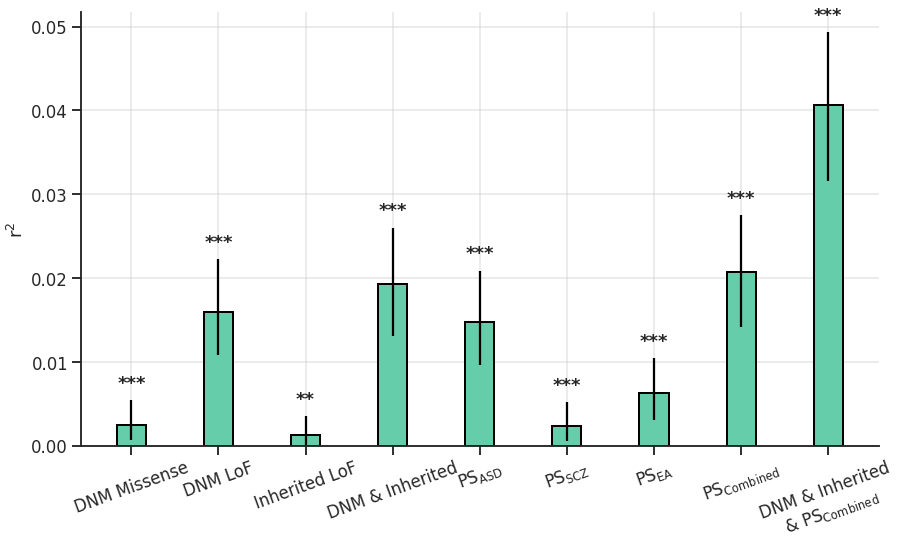

In [8]:
# Figure 2A
# Functions
def format_p(pv):
    fmt = ''
    if pv < 0.05: fmt='*'
    if pv < 0.01: fmt='**'
    if pv < 0.001: fmt='***'
    return fmt

# Data analysis
df = pd.read_csv("R2_estimates.bootstrap-test-convergence.csv", sep=",")


# Reformat data
df[["R2_type", "Sex"]] = df['text'].str.split('_', 1, expand=True)
df['Sex'] = df['Sex'].replace({"both": "Female & Male", "female": "Female", "male": "Male"})
# To get the error bars, Danny uses the upper confidence interval value (shortcut?)
df['ci']= df['ci_upper'] - df['nagelkerke_R2_val']
df["ci_lower_adj"] = df["nagelkerke_R2_val"] - df["ci_lower"]
df["ci_upper_adj"] = df["ci_upper"] - df["nagelkerke_R2_val"]


# Rename columns for R2_type (for now?)
df["R2_type"] = df["R2_type"].replace({
    "combined": "all_combined",
    "prs": "prs_combined",
    "rare": "rare_combined",
    "ptdt.asd.dev": "prs_asd_load",
    "ptdt.ea.dev": "prs_ea_load",
    "ptdt.scz.dev": "prs_scz_load",
    "dnMIS": "snv_dn_mis",
    "dnLOF": "snv_dn_lof",
    "inhLOF": "snv_lof_t"
})


# Plotting
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
sns.set_context('talk')
pal = ['mediumaquamarine','dodgerblue','silver']

f, ax = plt.subplots(1,1,figsize=(13,8))

risk = [
    'snv_dn_mis','snv_dn_lof',
    'snv_lof_t',
    'rare_combined',
    'prs_asd_load','prs_scz_load','prs_ea_load',
    'prs_combined',
    'all_combined'
]

ybar = np.array([x for x in range(0, len(risk))])


r2, err, pv = [], [], []
ci_lower, ci_upper = [], []
ci_lower_upper = []
for r in risk:
  r2.append(df[(df['Sex'] == 'Female & Male') & (df['R2_type'] == r)]['nagelkerke_R2_val'].values[0])
  err.append(df.loc[(df['Sex'] == 'Female & Male') & (df['R2_type'] == r)]['ci'].values[0])
  pv.append(df.loc[(df['Sex'] == 'Female & Male') & (df['R2_type'] == r)]['lr_p_val'].values[0])
  ci_lower.append(df.loc[(df['Sex'] == 'Female & Male') & (df['R2_type'] == r)]['ci_lower_adj'].values[0])
  ci_upper.append(df.loc[(df['Sex'] == 'Female & Male') & (df['R2_type'] == r)]['ci_upper_adj'].values[0])


ci_lower_upper = (ci_lower, ci_upper)

width = 1/3

ax.bar(
    x = ybar,
    height = r2,
    width = width,
    # yerr = err,
    yerr = ci_lower_upper,
    color = pal[0],
    edgecolor = "k",
    linewidth = 2,
)

# p-values
pbuf = 0.002
buff = 0
for i, p in enumerate(pv):
  ax.text(
      y = r2[i] + err[i] + pbuf,
      # y = r2[i] + pbuf,
      x = ybar[i] + buff,
      s = format_p(p),
      ha = 'center',
      va = 'center',
      weight = 'bold',
      )

xlabs = [
    'DNM Missense','DNM LoF','Inherited LoF','DNM & Inherited',
    '$PS_{ASD}$','$PS_{SCZ}$','$PS_{EA}$',
    '$PS_{Combined}$',
    'DNM & Inherited\n& $PS_{Combined}$'
]

ax.set_ylabel('r$^2$')
ax.set_xlabel('')
ax.set_xticks([x for x in ybar])
ax.set_xticklabels(xlabs,rotation=20)
ax.xaxis.grid(alpha=0.5)
ax.yaxis.grid(alpha=0.5)
ax.set_axisbelow(True)
sns.despine(ax=ax)
f.tight_layout()
f.savefig("fig1_model_final_hor.png")
f.savefig("fig1_model_final_hor.svg")

In [9]:
# Make supplementary table 5
df = pd.read_csv("R2_estimates.bootstrap-test-convergence.csv", sep=",")

# Reformat data
df[["R2_type", "Sex"]] = df['text'].str.split('_', 1, expand=True)
df['Sex'] = df['Sex'].replace({"both": "Female & Male", "female": "Female", "male": "Male"})

df = df.rename(columns = {"text": "Model",
                          "nagelkerke_R2_val": "r2",
                          "ci_lower": "Lower 95% CI",
                          "ci_upper": "Upper 95% CI",
                          "lr_p_val": "P-Value",
                          "ste": "Standard Error"})

df = df[df["Sex"] == "Female & Male"]
df = df[["Model", "r2", "P-Value", "Standard Error", "Lower 95% CI", "Upper 95% CI"]]


df['Model'].replace({'combined_both': 'All Combined', 
                     'prs_both': 'PS Combined', 
                     'rare_both': 'Rare Combined', 
                     'ptdt.asd.dev_both': 'PS ASD',
                     'ptdt.ea.dev_both': 'PS EA',
                     'ptdt.scz.dev_both': 'PS SCZ',
                     'dnMIS_both': 'dnMIS',
                     'dnLOF_both': 'dnLoF',
                     'inhLOF_both': 'inhLoF'}, inplace = True)

df = df.reset_index(drop=True)
df = df.reindex([0,1,2,3,4,5,7,6,8])

cols = ["Model", "r2", "Lower 95% CI", "Upper 95% CI", "P-Value", "Standard Error"]
df = df[cols]

df.to_csv("SupplementaryTable5.Results_Fig2a.csv", index=False)


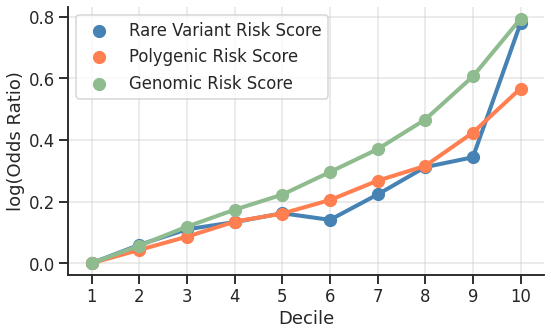

In [10]:
# Figure 2B
# df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20200625.csv", sep=",")
# df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20210709.csv", sep=",")
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210709.csv", sep=",")

df = df.dropna(subset=["GRS", "PRS", "RVRS"])


df['Sex'] = df['Sex'].replace({0:'Male', 1:'Female'})
df['Phenotype'] = df['Phenotype'].replace({0:'Control', 1:'ASD'})

def response_or(df):
  """
                    asd   |  con
      at thres    | a     |   b
      below thres | c     |   d
      
      OR = a/c / b/d
  """
  results = []
  for x in range(1,11):
    a = len(df[(df["Phenotype"] == "ASD")     & (df["response_deciles"] >= x)])
    b = len(df[(df["Phenotype"] == "Control") & (df["response_deciles"] >= x)])
    c = len(df[df["Phenotype"] == "ASD"])
    d = len(df[df["Phenotype"] == "Control"])

    # Make a 2x2 contigency table
    table = Table2x2([[a,b], [c,d]], shift_zeros=True)
    c_, p, dof, expected = chi2_contingency([[a,b],[c,d]])
    lo,hi = table.oddsratio_confint()
    results.append([x, table.oddsratio, lo, hi, p, a, b, c, d])
  return results

df["response_deciles"] = pd.qcut(df["GRS"], q = 10, labels = [x for x in range(1,11)])
co = response_or(df)
df["response_deciles"]=pd.qcut(df["PRS"], q = 10, labels=[x for x in range(1,11)])
ps = response_or(df)
df["response_deciles"]=pd.qcut(df["RVRS"], q = 10, labels = [x for x in range(1,11)])
ra = response_or(df)

# Write results to file
ofh = open('response_oddsratio.tsv', 'w')
header = ['feat','decile','or','lo','hi','chi','asd_gt','con_gt','asd_lt','con_lt']
ofh.write('\t'.join(header) + '\n')
for x in co:
    ofh.write('Genomic Risk Score\t' + '\t'.join(map(str,x)) + '\n')
for x in ps:
    ofh.write('Polygenic Risk Score\t' + '\t'.join(map(str,x)) + '\n')
for x in ra:
    ofh.write('Rare Variant Risk Score\t' + '\t'.join(map(str,x)) + '\n')
ofh.close()

# Read results
df = pd.read_csv("response_oddsratio.tsv", sep="\t")
df["logodds"] = np.log(df["or"])

# Plotting
sns.set_context("talk")
f, ax = plt.subplots(1, 1, figsize = (8,5))

sns.pointplot(
    x='decile',
    y='logodds',
    data=df,
    hue='feat',
    hue_order=['Rare Variant Risk Score', 'Polygenic Risk Score', 'Genomic Risk Score'],
    palette=['steelblue', 'coral', 'darkseagreen'],
    saturation=1,
)

# ax.errorbar(
#     x = df["decile"],
#     y = df["logodds"],
#     yerr = np.abs(df["hi"]) - np.abs(df["lo"]),
#     )

ax.xaxis.grid(alpha=0.5)
ax.yaxis.grid(alpha=0.5)
ax.legend(loc=2,title='')
ax.set_axisbelow(True)
sns.despine(ax=ax)
ax.set_xlabel('Decile')
ax.set_ylabel('log(Odds Ratio)')
f.tight_layout()
f.savefig("Fig2_response_odds.svg")
f.savefig("Fig2_response_odds.png")

In [11]:
# feat, decile, or, lo (ci), hi (ci), chi, asd_gt (cases > decile threshold), con_gt (controls > decile threshold), asd_lt (total #), con_lt (total #)
df_st5 = pd.read_csv("response_oddsratio.tsv", sep="\t")

df_st5 = df_st5.rename(columns = {"feat": "Risk score",
                                  "decile": "Decile",
                                  "or": "Odds Ratio",
                                  "lo": "Odds Ratio Lower 95% CI",
                                  "hi": "Odds Ratio Upper 95% CI",
                                  "chi": "ChiSq P-Value",
                                  "asd_gt": "Cases > Decile Threshold",
                                  "con_gt": "Controls > Decile Threshold",
                                  "asd_lt": "Cases Total",
                                  "con_lt": "Controls Total",
                                  })

df_st5 = df_st5[["Risk score", "Decile", 
                 "Cases > Decile Threshold", "Controls > Decile Threshold",
                 "Cases Total", "Controls Total", 
                 "Odds Ratio", "Odds Ratio Lower 95% CI", "Odds Ratio Upper 95% CI",
                 "ChiSq P-Value"]]

df_st5.to_csv("SupplementaryTable5.Results_Fig2B.csv", index=False)


In [12]:
df  = df_st5[["Risk score", "Decile", "Odds Ratio"]]
df = df.pivot(index = "Decile", columns='Risk score', values='Odds Ratio')

df = df.rename(columns = {"Genomic Risk Score": "GRS",
                          "Rare Variant Risk Score": "RVRS",
                          "Polygenic Risk Score": "PRS",
                         })


# Axis = 0 applies the function (log10) to each column, giving you the log10 odds ratios
df = df.apply(np.log10, axis = 0)



df["GRS vs RVRS"] = (df["GRS"] - df["RVRS"])/df["RVRS"]
df["GRS vs PRS"] = (df["GRS"] - df["PRS"])/df["PRS"]

df['GRS vs RVRS'] = df['GRS vs RVRS'].fillna(0)
df['GRS vs PRS'] = df['GRS vs PRS'].fillna(0)

df['GRS vs RVRS'] = df['GRS vs RVRS']*100
df['GRS vs PRS'] = df['GRS vs PRS']*100


# Print means of percent increases in effect sizes
print(df["GRS vs RVRS"].mean())
print(df["GRS vs PRS"].mean())


df.to_csv("logOR_comparison_Fig2B.csv", sep=",")


37.513579725068716
34.95287040950061


# Figure 3

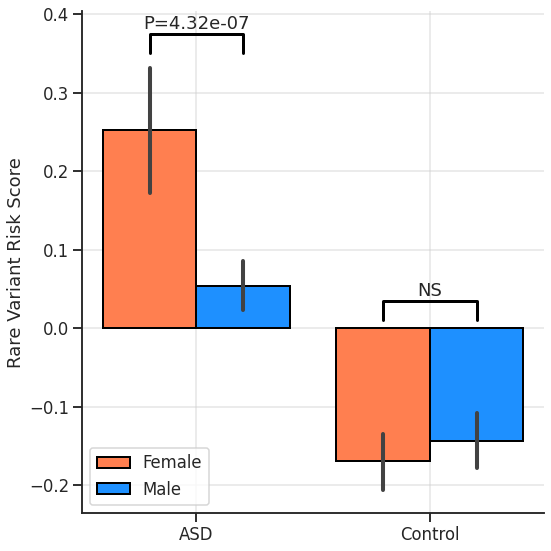

In [13]:
# Figure 3A
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.csv", sep=",")
# df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20200625.csv", sep=",")
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210709.csv", sep=",")



feature = "RVRS"
df = df.dropna(subset=[feature])

df['Sex'] = df['Sex'].replace({0:'Male', 1:'Female'})
df['Phenotype'] = df['Phenotype'].replace({0:'Control', 1:'ASD'})

asd_male_num = len(df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Male")])
asd_male_vals = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Male")][feature]
asd_female_num = len(df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Female")])
asd_female_vals = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Female")][feature]
con_male_num = len(df[(df["Phenotype"] == "Control") & (df["Sex"] == "Male")])
con_male_vals = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Male")][feature]
con_female_num = len(df[(df["Phenotype"] == "Control") & (df["Sex"] == "Female")])
con_female_vals = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Female")][feature]

asd_male_female_p_value = scipy.stats.ttest_ind(asd_male_vals, asd_female_vals)[1]
con_male_female_p_value = scipy.stats.ttest_ind(con_male_vals, con_female_vals)[1]

# Plotting
sns.set_context("talk")
f, ax = plt.subplots(1, 1, figsize = (8,8))
ax = sns.barplot(
    x = "Phenotype",
    y = feature,
    hue = "Sex",
    data = df,
    hue_order=['Female','Male'],
    order = ["ASD","Control"],
    palette = ['coral','dodgerblue'],
    linewidth = 2,
    edgecolor = "k",
    saturation = 1,
    ax = ax
)

x_pos = []
for pos in ax.patches:
    x_pos.append(pos.get_x() + pos.get_width()/2.)

# Add p-values
height = 0.025

# Cases
y = 0.335
y = 0.35

s = "NS"
if asd_male_female_p_value <= 0.05:
  s = 'P={:.2e}'.format(asd_male_female_p_value)
ax.plot([x_pos[0], x_pos[0], x_pos[2], x_pos[2]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[0] + x_pos[2])/2.,
    y = y + (1.5 * height),
    s = s,
    ha = "center",
    va = "center"           
)

# Controls
y = 0.01
s = "NS"
if con_male_female_p_value <= 0.05:
  s = 'P={:.2e}'.format(con_male_female_p_value)
ax.plot([x_pos[1], x_pos[1], x_pos[3], x_pos[3]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[1] + x_pos[3])/2.,
    y = y + (1.5 * height),
    s = s,
    ha = "center",
    va = "center"           
)


ylabel = "Rare Variant Risk Score"

ax.set_xticklabels(['ASD','Control'])
ax.set_xlabel("")
ax.set_ylabel(ylabel)
ax.xaxis.grid(alpha=0.5)
ax.yaxis.grid(alpha=0.5)
ax.legend(loc=3,title='')
ax.set_axisbelow(True)
sns.despine(ax=ax)
f.tight_layout()
f.savefig("Fig3A.png")
f.savefig("Fig3A.svg")

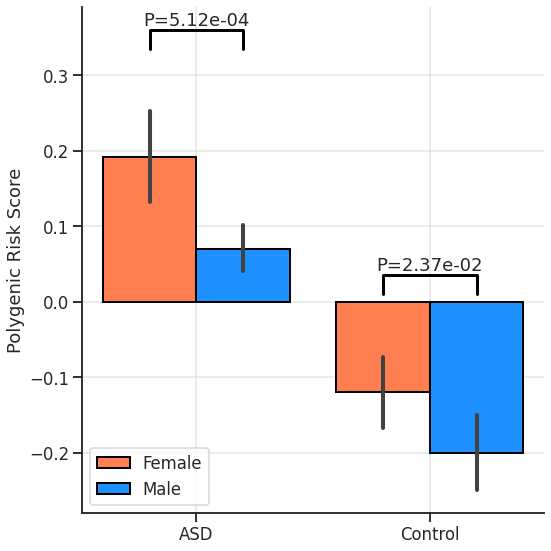

In [14]:
# Figure 3B
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.residv2.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.residv1.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.resid3.csv", sep=",")
# df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20200625.csv", sep=",")
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210709.csv", sep=",")


feature = "PRS"
df = df.dropna(subset=[feature])

df['Sex'] = df['Sex'].replace({0:'Male', 1:'Female'})
df['Phenotype'] = df['Phenotype'].replace({0:'Control', 1:'ASD'})

asd_male_num = len(df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Male")])
asd_male_vals = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Male")][feature]
asd_female_num = len(df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Female")])
asd_female_vals = df[(df["Phenotype"] == "ASD") & (df["Sex"] == "Female")][feature]
con_male_num = len(df[(df["Phenotype"] == "Control") & (df["Sex"] == "Male")])
con_male_vals = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Male")][feature]
con_female_num = len(df[(df["Phenotype"] == "Control") & (df["Sex"] == "Female")])
con_female_vals = df[(df["Phenotype"] == "Control") & (df["Sex"] == "Female")][feature]

asd_male_female_p_value = scipy.stats.ttest_ind(asd_male_vals, asd_female_vals)[1]
con_male_female_p_value = scipy.stats.ttest_ind(con_male_vals, con_female_vals)[1]


# Plotting
sns.set_context("talk")
f, ax = plt.subplots(1, 1, figsize = (8,8))
ax = sns.barplot(
    x = "Phenotype",
    y = feature,
    hue = "Sex",
    data = df,
    hue_order=['Female','Male'],
    order = ["ASD","Control"],
    palette = ['coral','dodgerblue'],
    linewidth = 2,
    edgecolor = "k",
    saturation = 1,
    ax = ax
)

x_pos = []
for pos in ax.patches:
    x_pos.append(pos.get_x() + pos.get_width()/2.)

# Add p-values
height = 0.025
# Cases
y = 0.335
s = "NS"
if asd_male_female_p_value <= 0.05:
  s = 'P={:.2e}'.format(asd_male_female_p_value)
ax.plot([x_pos[0], x_pos[0], x_pos[2], x_pos[2]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[0] + x_pos[2])/2.,
    y = y + (1.5 * height),
    s = s,
    ha = "center",
    va = "center"           
)

# Controls
y = 0.01
s = "NS"
if con_male_female_p_value <= 0.05:
  s = 'P={:.2e}'.format(con_male_female_p_value)
ax.plot([x_pos[1], x_pos[1], x_pos[3], x_pos[3]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[1] + x_pos[3])/2.,
    y = y + (1.5 * height),
    s = s,
    ha = "center",
    va = "center"           
)


ylabel = "Polygenic Risk Score"

ax.set_xticklabels(['ASD','Control'])
ax.set_xlabel("")
ax.set_ylabel(ylabel)
ax.xaxis.grid(alpha=0.5)
ax.yaxis.grid(alpha=0.5)
ax.legend(loc=3,title='')
ax.set_axisbelow(True)
sns.despine(ax=ax)
f.tight_layout()
f.savefig("Fig3B.png")
f.savefig("Fig3B.svg")

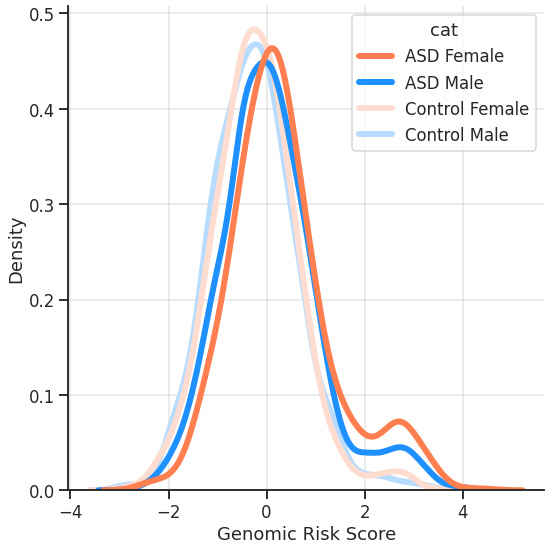

In [15]:
# Figure 3C
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.residv2.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.residv1.csv", sep=",")
# df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20200625.csv", sep=",")
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210709.csv", sep=",")


df = df.dropna(subset=["GRS"])


df['Sex'] = df['Sex'].replace({0:'Male', 1:'Female'})
df['Phenotype'] = df['Phenotype'].replace({0:'Control', 1:'ASD'})
df['cat']=df['Phenotype']+' '+df['Sex']

# Plotting
sns.set_context('talk')
f, ax = plt.subplots(1, 1, figsize=(8,8))

sns.kdeplot(
    data=df,
    x="GRS",
    hue="cat",
    linewidth=6,
    hue_order=['ASD Female','ASD Male','Control Female','Control Male'],
    palette=['coral','dodgerblue','#ffdcd0','#b8dcff'],
    alpha=0.8,
    common_norm=False,
    legend='brief',
    multiple="layer",
    ax=ax)

sns.despine(ax=ax)
ax.xaxis.grid(alpha=0.5)
ax.yaxis.grid(alpha=0.5)
ax.set_axisbelow(True)
ax.set_xlabel('Genomic Risk Score')
f.tight_layout()
f.savefig("Fig3C.png")
f.savefig("Fig3C.svg")



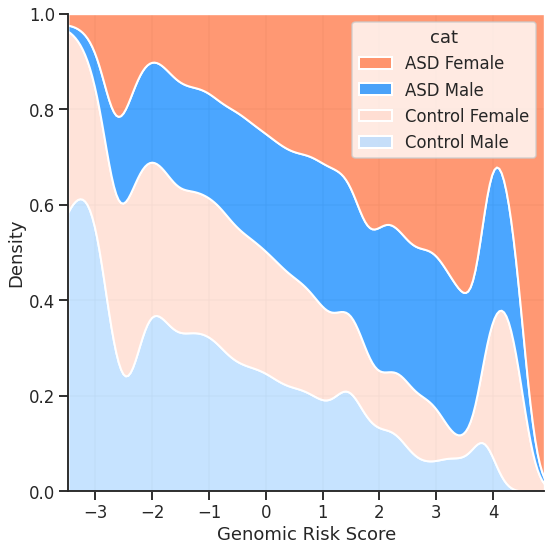

In [16]:
# Figure 3D
sns.set_context('talk')
f, ax = plt.subplots(1,1,figsize=(8,8))

sns.kdeplot(
    data=df,
    x="GRS",
    hue="cat",
    linewidth=2,
    hue_order=['ASD Female','ASD Male','Control Female','Control Male'],
    palette=['coral','dodgerblue','#ffdcd0','#b8dcff'],
    alpha=0.8,
    common_norm=False,
    legend='brief',
    multiple="fill",
    ax=ax)

sns.despine(ax=ax)
ax.xaxis.grid(alpha=0.5)
ax.yaxis.grid(alpha=0.5)
ax.set_axisbelow(True)
ax.set_xlabel('Genomic Risk Score')
f.tight_layout()
f.savefig("Fig3D.png")
f.savefig("Fig3D.svg")

# Figure 4

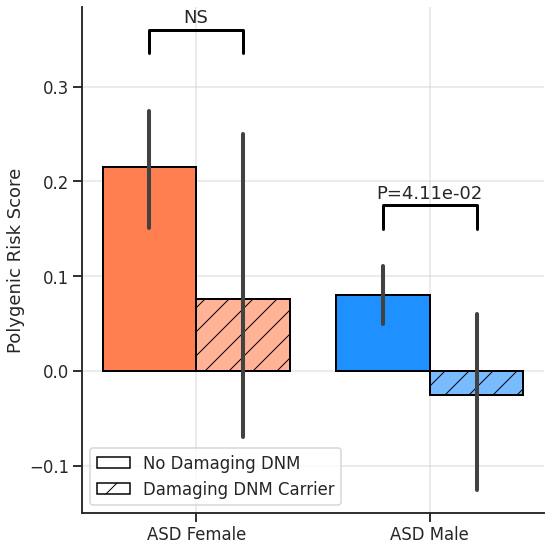

In [17]:
# Figure 4A

# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.residv2.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.residv1.csv", sep=",")
# df = pd.read_csv("SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.resid3.csv", sep=",")
# df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20200625.csv", sep=",")
df = pd.read_csv("/content/SummaryGeneticData_REACH_SSC_SPARK.responses.SBayesR.20210709.csv", sep=",")


feature = "PRS"
df = df.dropna(subset=[feature])

# df['Sex'] = df['Sex'].replace({0:'Male', 1:'Female'})
df['Phenotype'] = df['Phenotype'].replace({0:'Control', 1:'ASD'})
df["dnAll"] = df["dnLOF"] + df["dnMIS"]

# Samples only with ASD now
df = df[df["Phenotype"] == "ASD"]
df["dnBool"] = df["dnAll"] > 0
df['Sex'] = df['Sex'].replace({0:'ASD Male', 1:'ASD Female'})
df['dnBool'] = df['dnBool'].replace({True:'Damaging DNM Carrier', False:'No Damaging DNM'})

# ASD: no damaging DNM female vs. damaging DNM female
asd_female_dnm = df[(df["dnBool"] == "Damaging DNM Carrier") & (df["Sex"] == "ASD Female")]
asd_female_no_dnm = df[(df["dnBool"] == "No Damaging DNM") & (df["Sex"] == "ASD Female")]
asd_male_dnm = df[(df["dnBool"] == "Damaging DNM Carrier") & (df["Sex"] == "ASD Male")]
asd_male_no_dnm = df[(df["dnBool"] == "No Damaging DNM") & (df["Sex"] == "ASD Male")]

asd_female_dnm_num = len(asd_female_dnm)
asd_female_dnm_vals = asd_female_dnm[feature]
asd_female_no_dnm_num = len(asd_female_no_dnm)
asd_female_no_dnm_vals = asd_female_no_dnm[feature]

asd_male_dnm_num = len(asd_male_dnm)
asd_male_dnm_vals = asd_male_dnm[feature]
asd_male_no_dnm_num = len(asd_male_no_dnm)
asd_male_no_dnm_vals = asd_male_no_dnm[feature]

# asd_no_dnm_male_male_dnm_p_value = scipy.stats.ttest_ind(asd_male_no_dnm_vals, asd_male_dnm_vals)
# asd_dnm_female_no_dnm_female_p_value = scipy.stats.ttest_ind(asd_female_no_dnm_vals, asd_female_dnm_vals)

asd_male_dnm_no_dnm_p_value = scipy.stats.ttest_ind(asd_male_dnm_vals, asd_male_no_dnm_vals)
asd_female_dnm_no_dnm_p_value = scipy.stats.ttest_ind(asd_female_dnm_vals, asd_female_no_dnm_vals)

# Plotting
sns.set_context("talk")
f , ax = plt.subplots(1,1,figsize=(8,8))

ax = sns.barplot(
    x="Sex",
    y=feature,
    hue="dnBool",
    data=df,
    hue_order=['No Damaging DNM','Damaging DNM Carrier'],
    order=['ASD Female','ASD Male'],
    palette=['bisque','mediumaquamarine'],
    linewidth=2,
    edgecolor='k',
    saturation=1,
    ax=ax,
)


x_pos = []
for i, p in enumerate(ax.patches):
    x_pos.append(p.get_x() + p.get_width()/2.)
    if i == 2 or i == 3:
        p.set_hatch('/')
    if i == 0:
        p.set_color('coral')
    if i == 2:
        p.set_color('#ffb296')
    if i == 1: 
        p.set_color("dodgerblue")
    if i == 3:
        p.set_color("#78bcff")
    p.set_linewidth(2)
    p.set_edgecolor('k')


# Add p-values (females)
height = 0.025
y = 0.335
s = "NS"
if asd_female_dnm_no_dnm_p_value[1] <= 0.05:
  s = 'P={:.2e}'.format(asd_female_dnm_no_dnm_p_value[1])
ax.plot([x_pos[0], x_pos[0], x_pos[2], x_pos[2]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[0] + x_pos[2])/2.,
    y = y + (1.5 * height),
    s = s,
    ha = "center",
    va = "center"           
)

# Add p-values (males)
height = 0.025
y = 0.15
s = "NS"
if asd_male_dnm_no_dnm_p_value[1] <= 0.05:
  s = 'P={:.2e}'.format(asd_male_dnm_no_dnm_p_value[1])
ax.plot([x_pos[1], x_pos[1], x_pos[3], x_pos[3]], [y, y + height, y + height, y], lw = 3, c = 'k')
ax.text(
    x = (x_pos[1] + x_pos[3])/2.,
    y = y + (1.5 * height),
    s = s,
    ha = "center",
    va = "center"           
)



ax.set_xlabel("")
ax.set_ylabel(ylabel)
ax.xaxis.grid(alpha=0.5)
ax.yaxis.grid(alpha=0.5)

leg = [
    Patch(facecolor='white',edgecolor='k',label='No Damaging DNM'),
    Patch(facecolor='white',edgecolor='k',hatch='/',label='Damaging DNM Carrier')
]

ax.legend(loc=3,title='',handles=leg)
ax.set_axisbelow(True)
sns.despine(ax=ax)
f.tight_layout()
f.savefig("Fig4A.png")
f.savefig("Fig4A.svg")

# Figure 6

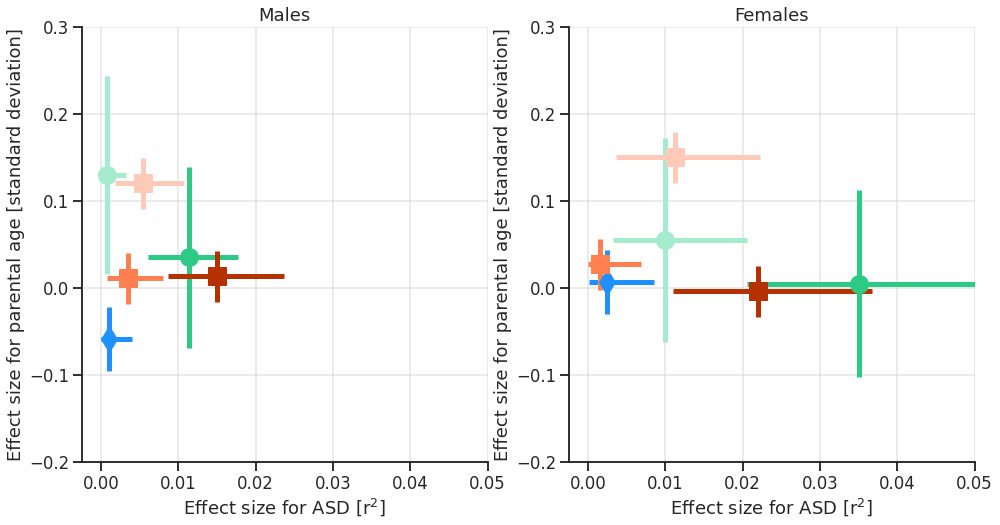

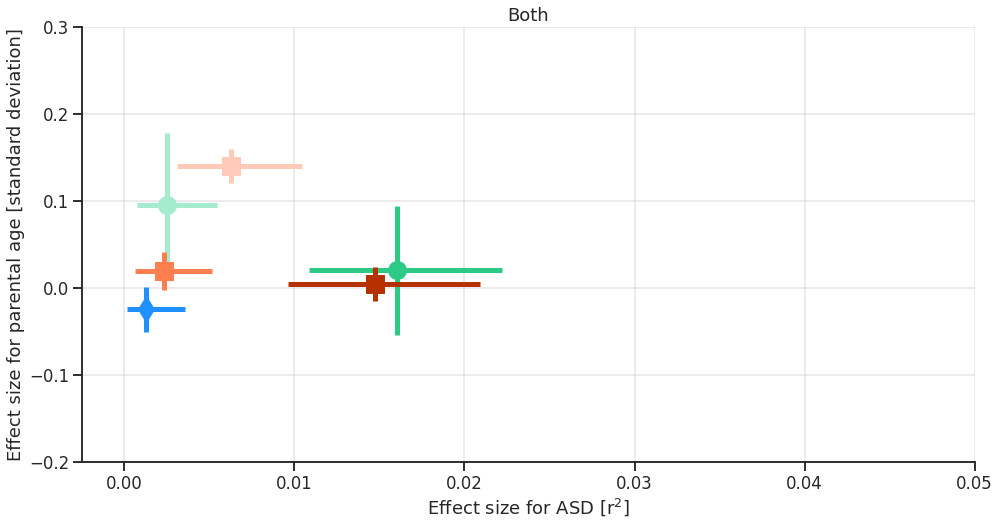

In [19]:
# Figure 6
# Get Parental Age Estimates Table and reformat it
# df_clin = pd.read_csv("clin_results_eur.csv", sep=",")
# df_clin = pd.read_csv("/content/clin_results_eur.SBayesR.csv", sep=",")
df_clin = pd.read_csv("/content/clin_results_eur.SBayesR.20210709.csv", sep=",")

df_clin = df_clin[["case.status", "phenotype", "group", "variant.type", "r.sq", "est", "est.stderr", "pearson.cc", "x.pval", "sex.pval"]]
df_clin["variant.type"] = df_clin["variant.type"].replace({
    "dnmis": "dnMIS",
    "dnlof": "dnLOF",
    "inhLoF": "inhLOF",
    "ps.asd": "PS ASD",
    "ps.ea": "PS EA",
    "ps.sz": "PS SCZ"
})
df_clin_parental_age = df_clin[df_clin["phenotype"] == "Parental Age"]

# Add sex column based on "group" column value
def set_sex(df_row):
  if df_row["group"] == "mother":
    return "female"
  elif df_row["group"] == "father":
    return "male"
  else:
    return "both"
df_clin_parental_age = df_clin_parental_age.assign(Sex=df_clin_parental_age.apply(set_sex, axis=1))
df_clin_parental_age = df_clin_parental_age.reset_index(drop=True)
# "Hacky" way of getting confidence interval from standard error
df_clin_parental_age["est.ci"] = df_clin_parental_age["est.stderr"]*1.96

# Get R2 Table and reformat it
# df_r2 = pd.read_csv("R2_estimates.csv", sep=",", index_col=0)
df_r2 = pd.read_csv("/content/R2_estimates.bootstrap-test-convergence.csv", sep=",")

df_r2["ci_lower_adj"] = df_r2["nagelkerke_R2_val"] - df_r2["ci_lower"]
df_r2["ci_upper_adj"] = df_r2["ci_upper"] - df_r2["nagelkerke_R2_val"]

# df_r2[["R2_type", "Sex"]] = df_r2['R2_type'].str.split('_', 1, expand=True)
df_r2[["R2_type", "Sex"]] = df_r2['text'].str.split('_', 1, expand=True)
df_r2 = df_r2.rename(columns = {"R2_type": "variant.type"})
df_r2 = df_r2[(df_r2["variant.type"] == "dnLOF") | 
              (df_r2["variant.type"] == "dnMIS") |
              (df_r2["variant.type"] == "inhLOF") |
              (df_r2["variant.type"] == "ptdt.asd.dev") |
              (df_r2["variant.type"] == "ptdt.ea.dev") |
              (df_r2["variant.type"] == "ptdt.scz.dev")
              ]
df_r2["variant.type"] = df_r2["variant.type"].replace({
    "ptdt.asd.dev": "PS ASD",
    "ptdt.ea.dev": "PS EA",
    "ptdt.scz.dev": "PS SCZ"
})



df_r2 = df_r2.reset_index(drop=True)
# Merge Parental Age Estimates Table and R2 Table.
df_merge = df_clin_parental_age.merge(df_r2, on=["variant.type", "Sex"])


# Plotting
df = df_merge
def draw_plot(ax, df_in, index):
  ax.errorbar(
      x = df_in["nagelkerke_R2_val"],
      y = df_in["est"],
      # xerr = np.abs(df_in["ci"]),
      xerr = (np.abs(df_in["ci_lower_adj"]), np.abs(df_in["ci_upper_adj"])),
      yerr = np.abs(df_in["est.ci"]),
      fmt = "o",
      marker = mak[index],
      color = pal[index],
      markersize = 18,
      label = entry,
      linewidth = 5,
  )
  ax.set_xlabel("Effect size for ASD [r$^2$]")
  ax.set_ylabel("Effect size for parental age [standard deviation]")
  ax.xaxis.grid(alpha=0.5)
  ax.yaxis.grid(alpha=0.5)
  sns.despine(ax=ax)
  ax.set_ylim(-0.2,0.3)
  ax.set_xlim(-0.0025,0.05)



sns.set_context("talk")
mod = ['dnMIS','dnLOF','inhLOF','PS ASD','PS SCZ','PS EA']
pal = ['#a5ebcd','#2dca86','dodgerblue','#b63100','coral','#ffcab7']
mak = ['o','o','d','s','s','s']


f, ax = plt.subplots(1,2,figsize=(16,8))


for index,entry in enumerate(mod):
  df_male = df[(df["variant.type"] == entry) & (df["Sex"] == "male")]
  df_female = df[(df["variant.type"] == entry) & (df["Sex"] == "female")]
  draw_plot(ax[0], df_male, index)
  draw_plot(ax[1], df_female, index)
  ax[0].set_title("Males")
  ax[1].set_title("Females")


f2, ax2 = plt.subplots(1,1,figsize=(16,8))
for index, entry in enumerate(mod):
  df_both = df[(df["variant.type"] == entry) & (df["Sex"] == "both")]
  draw_plot(ax2, df_both, index)
  ax2.set_title("Both")


In [22]:
# Zip and download all the data
!zip -r /content/Antaki2021_figure_data.zip /content
from google.colab import files
files.download("/content/Antaki2021_figure_data.zip")


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 24%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2021.07.01/ (stored 0%)
  adding: content/.config/logs/2021.07.01/13.40.56.775713.log (deflated 91%)
  adding: content/.config/logs/2021.07.01/13.41.17.729047.log (deflated 54%)
  adding: content/.config/logs/2021.07.01/13.41.40.038589.log (deflated 54%)
  adding: content/.config/logs/2021.07.01/13.41.33.930553.log (deflated 86%)
  adding: content/.config/logs/2021.07.01/13.41.56.945079.l

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>